In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
cd '/content/gdrive/My Drive/VIP_Project'

/content/gdrive/My Drive/VIP_Project


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pylab as plt

In [ ]:
num_epoch = 100
batch_size = 1000

in_timesteps  = range(0,19)
out_timesteps = range(1,20)

# prepare data
data = np.load( "moving-shapes-2-tr-images.npy" )

# training set
x_tr = data[:5000,in_timesteps]
y_tr = data[:5000,out_timesteps]
tr_set = data[0:5000, :, :, :]

# validation set
x_te = data[5000:6000,in_timesteps]
y_te = data[5000:6000,out_timesteps]
te_set = data[5000:6000, :, :, :]

#print (np.shape(x_tr), np.shape(y_tr), np.shape(x_te), np.shape(y_te))
print (np.shape(x_te), np.shape(y_te))

(1000, 19, 64, 64, 3) (1000, 19, 64, 64, 3)


In [ ]:
seq = keras.Sequential(
    [
        keras.Input(
            shape=(None, 64, 64, 3)
        ),  # Variable-length sequence of 40x40x1 frames
        layers.ConvLSTM2D(
            filters=64, kernel_size=(3, 3), padding="same", return_sequences=True
        ),
        layers.BatchNormalization(),
        layers.Conv3D(
            filters=3, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
        ),
    ]
)
seq.compile(loss="binary_crossentropy", optimizer="adadelta")

In [ ]:
def generator(X, y, batch_size):
    while True:
        for start in range(0, len(X), batch_size):
            end = min(start + batch_size, len(X))
            yield np.array(X[start:end]/255), np.array(y[start:end]/255)

In [ ]:
batch_size=8

checkpoint_filepath = '/content/gdrive/My Drive/VIP_Project/ConvLSTM(Official)/ConvLSTM_Official'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
  )

In [ ]:
history = seq.fit_generator(
    generator(x_tr, y_tr, batch_size),
    steps_per_epoch = len(x_tr)/batch_size,
    epochs=100,
    verbose=1,
    validation_data=generator(x_te, y_te, batch_size),
    validation_steps = len(x_te)/batch_size,
    callbacks=[model_checkpoint_callback]
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
625/625 [==============================] - ETA: 0s - loss: 0.6533
Epoch 00001: val_loss improved from inf to 0.63260, saving model to /content/gdrive/My Drive/VIP_Project/ConvLSTM(Official)/ConvLSTM_Official
625/625 [==============================] - 147s 235ms/step - loss: 0.6533 - val_loss: 0.6326
Epoch 2/100
625/625 [==============================] - ETA: 0s - loss: 0.6132
Epoch 00002: val_loss improved from 0.63260 to 0.59546, saving model to /content/gdrive/My Drive/VIP_Project/ConvLSTM(Official)/ConvLSTM_Official
625/625 [==============================] - 146s 234ms/step - loss: 0.6132 - val_loss: 0.5955
Epoch 3/100
625/625 [==============================] - ETA: 0s - loss: 0.5877
Epoch 00003: val_loss improved from 0.59546 to 0.57431, saving model to /content/gdrive/My Drive/VIP_Project/ConvLSTM(Official)/ConvLSTM_Official
625/625 [==============================] - 147s 236ms/step - loss: 0.5

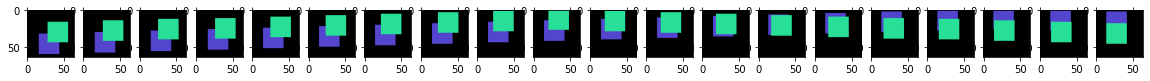

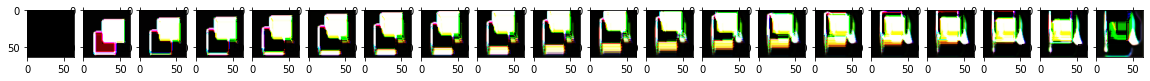

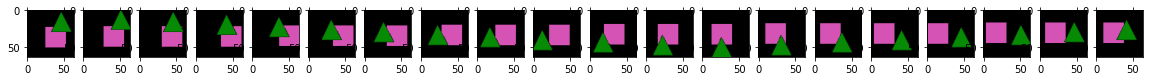

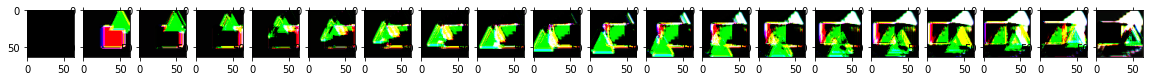

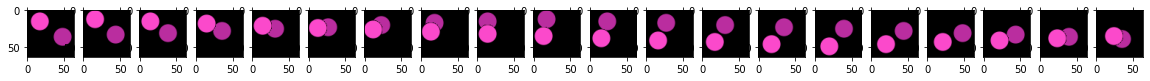

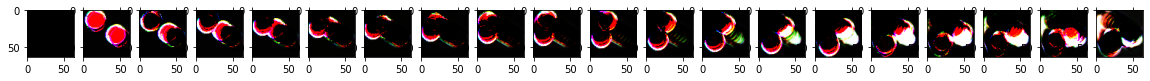

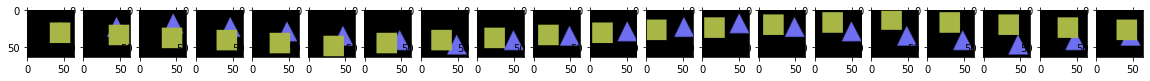

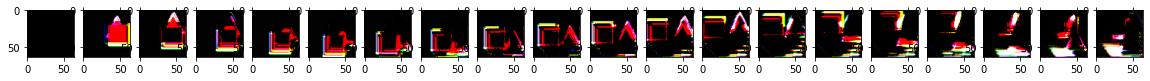

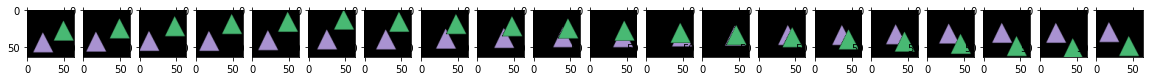

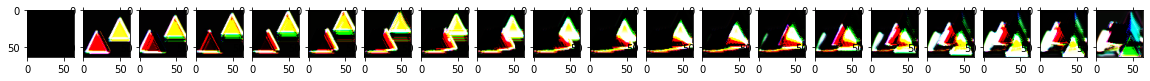

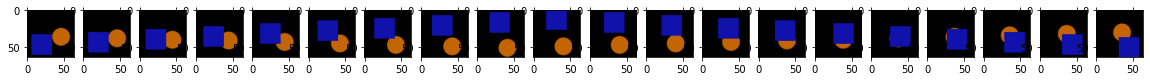

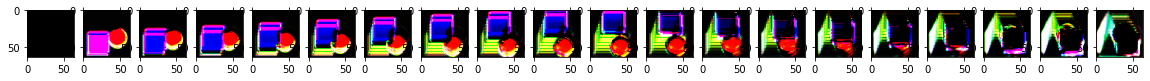

In [ ]:
batch_size = 1000
for sequence in range(1,7,1):
    track = x_te[sequence, :20, ::, ::, ::]
    y_prediction = seq.predict(track[np.newaxis])
    #print(y_prediction.shape)
    # ground truth
    plt.figure(figsize=(20,10))
    for i in range(20):
        plt.subplot(1, 20, i+1)
        plt.tick_params(
        axis='both',       # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off', # labels along the bottom edge are off
        labelleft='off')
        plt.imshow(te_set[sequence,i,:,:,:])

    # prediction
    plt.figure(figsize=(20,10))
    plt.subplot(1,20,1)
    plt.imshow(np.zeros((64,64,3)))
    for i in range(19):
        plt.subplot(1, 20, i+2) 
        plt.tick_params(
        axis='both',       # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off', # labels along the bottom edge are off
        labelleft='off')
        plt.imshow(y_prediction[0,i,:,:,:])

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from skimage.metrics import structural_similarity as ssim
from skimage import img_as_float32

te_set = img_as_float32(te_set)
y_prediction = seq.predict(x_te[:, :20, ::, ::, ::])

mse=0
mae=0
ssim_v=0

for i in range(batch_size):
  mse_i=0
  mae_i=0
  ssim_i=0
  for j in range(19):
    mse_total=0
    mae_total=0
    ssim_total=0
    for k in range(3):
      mse_total += mean_squared_error(te_set[i,j+1,:,:,k],y_prediction[i,j,:,:,k])
      mae_total += mean_absolute_error(te_set[i,j+1,:,:,k],y_prediction[i,j,:,:,k])
      ssim_total += ssim(te_set[i,j+1,:,:,k],y_prediction[i,j,:,:,k],data_range=y_prediction[i,j,:,:,k].max() - y_prediction[i,j,:,:,k].min())
    mse_i += mse_total/3
    mae_i += mae_total/3
    ssim_i += ssim_total/3

  mse += mse_i
  mae += mae_i
  ssim_v += ssim_i

mse = mse/(batch_size*19)
mae = mae/(batch_size*19)
ssim_v = ssim_v/(batch_size*19)

print('MSE: ',mse)
print('MAE: ',mae)
print('SSIM: ',ssim_v)

MSE:  0.13746363041943266
MAE:  0.19000781962728083
SSIM:  0.3379082211580086
